In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as c
from scipy.integrate import quad

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cols = ['luminosity_distance', 'mass_1'] # Only taking directly observable values
n_runs = 10   # number of random plots to make
n_m = 100    # resolution of mass points to find max over
n_mc = 5     # number of points to fit for the MCMC
m_cut = 25   # M_sun

mass_array = np.zeros((n_runs, n_mc))
d_ls = np.linspace(0, 50, n_mc)

In [3]:
for run in range(n_runs):
    df = False #janky method, alternative would be strongly appreciated

    for f in glob.glob('O3b-data/*mixed_cosmo.h5'):
        with h5py.File(f, 'r') as hf:
            post = np.array(hf['C01:Mixed/posterior_samples'])
            if (np.median(post['mass_1']) < m_cut) \
                and (np.median(post['luminosity_distance']) > 10000):
                continue
            data_array = np.random.choice(post, 1)
            if type(df) == bool: #janky method continued
                df = pd.DataFrame(data_array)[cols]
            else:
                if np.median(data_array['mass_1']) > m_cut:
                    df = pd.concat([df, pd.DataFrame(data_array)], ignore_index=True)[cols]

    for f in glob.glob('../LIGO-O3a-Posterior/all_posterior_samples/*comoving.h5'):
        with h5py.File(f, 'r') as hf:
            post = np.array(hf['PublicationSamples/posterior_samples'])
            if np.median(post['mass_1']) < m_cut:
                continue
            data_array = np.random.choice(post, 1)
            if type(df) == bool: #janky method continued
                df = pd.DataFrame(data_array)[cols]
            else:
                if np.median(data_array['mass_1']) > m_cut:
                    df = pd.concat([df, pd.DataFrame(data_array)], ignore_index=True)[cols]

    arr = np.array([df['luminosity_distance'], df['mass_1']])
    kde = gaussian_kde(arr)


    dlmin = 0
    dlmax = max(df['luminosity_distance'])
    mmin = 0
    mmax = max(df['mass_1'])

    DL, M = np.mgrid[dlmin:dlmax:n_mc*1j, mmin:mmax:n_m*1j]
    positions = np.vstack([DL.ravel(), M.ravel()])
    K = np.reshape(kde(positions).T, DL.shape)

#     d_ls = np.linspace(0, np.max(df['luminosity_distance'])/1000, n_mc)

    ms = np.linspace(0, np.max(df['mass_1']), n_m)

    for i, dl in enumerate(K):
        mass_array[run, i] = ms[np.argmax(dl)]



/home/tanner/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'Om'}>,
        <AxesSubplot:title={'center':'Om'}>],
       [<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'h'}>],
       [<AxesSubplot:title={'center':'m0'}>,
        <AxesSubplot:title={'center':'m0'}>],
       [<AxesSubplot:title={'center':'Ode'}>,
        <AxesSubplot:title={'center':'Ode'}>],
       [<AxesSubplot:title={'center':'om'}>,
        <AxesSubplot:title={'center':'om'}>],
       [<AxesSubplot:title={'center':'ode'}>,
        <AxesSubplot:title={'center':'ode'}>],
       [<AxesSubplot:title={'center':'dH'}>,
        <AxesSubplot:title={'center':'dH'}>],
       [<AxesSubplot:title={'center':'zs'}>,
        <AxesSubplot:title={'center':'zs'}>]], dtype=object)

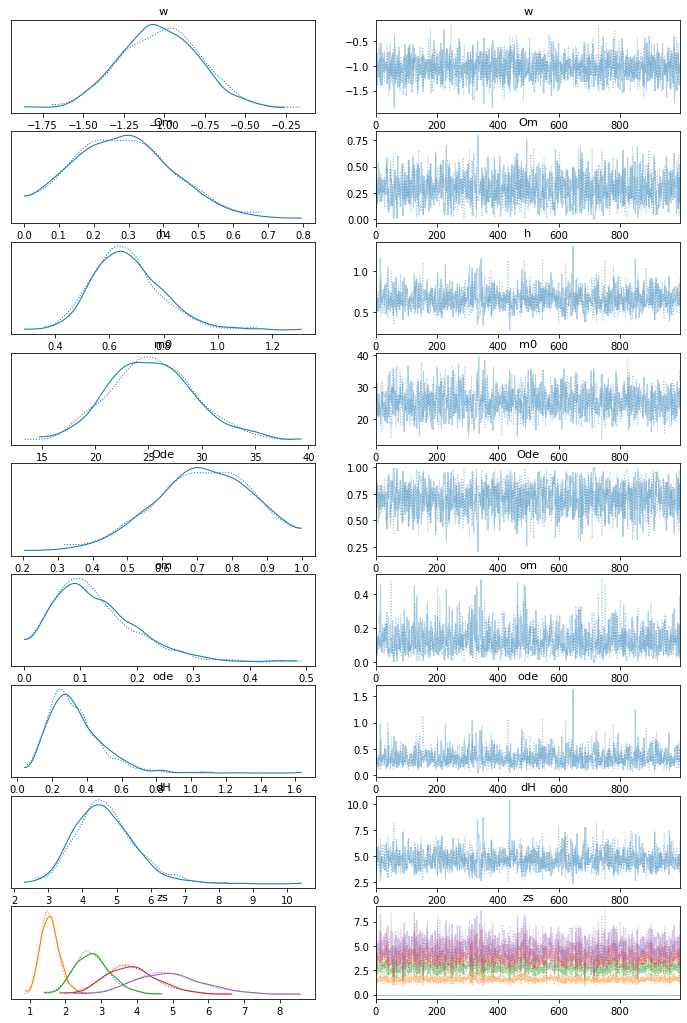

In [4]:
trace_cosmo = az.from_netcdf("O3a-bcosmo.nc")
az.plot_trace(trace_cosmo)

In [5]:
mass_array

array([[  8.31013263,  99.72159159, 116.34185686, 249.30397898,
        822.70313063],
       [ 31.6570004 ,  55.39975071,  75.18537596,  69.24968838,
        148.39218939],
       [ 31.99673543,  63.99347086,  95.99020629,  95.99020629,
        106.65578476],
       [  5.30986267,  53.09862672,  95.57752809, 122.12684145,
         84.95780275],
       [ 31.13197437,  80.94313336, 172.26359151, 153.58440689,
        205.47103084],
       [ 32.18430869,  46.26494374,  64.36861737,  68.39165596,
         70.40317525],
       [ 26.83208509,  51.60016363,  84.62426835,  70.17622253,
        165.1205236 ],
       [ 29.74995303,  63.46656646,  77.34987788,  71.39988727,
        152.71642556],
       [ 26.42433939,  62.75780606,  75.96997576, 158.54603636,
        163.5006    ],
       [  0.        , 102.70755   ,  84.03345   , 242.76329999,
        924.36794997]])

In [6]:
mass_mean = np.mean(mass_array, axis=0)
mass_std  = np.std(mass_array, axis=0)
print(mass_mean, mass_std)


[ 22.35963917  67.99536031  94.17047481 130.15322241 284.42886127] [ 11.96649833  18.88032651  29.41438584  66.36080588 297.89373862]


In [18]:
def d_L(z, h, Ode, Om):
    '''Luminosity distance from redshift assuming flat universe'''
    t_H = ((h*100*(u.km/u.s/u.Mpc))**-1).to(u.s)
    d_H = ((c.c*t_H).to(u.Mpc)).value
    return d_H * quad(lambda x: (Ode + Om*(1+x)**3)**-0.5 ,0, z)[0]

print(d_L(1, 0.7, 0.7, 0.3))

3303.8288058874673


In [8]:
t = trace_cosmo.posterior
t

<xarray.Dataset>
Dimensions:   (chain: 2, draw: 1000, zs_dim_0: 5)
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * zs_dim_0  (zs_dim_0) int64 0 1 2 3 4
Data variables:
    w         (chain, draw) float64 -1.332 -1.031 -1.206 ... -0.9075 -1.139
    Om        (chain, draw) float64 0.2796 0.08152 0.1377 ... 0.2189 0.3896
    h         (chain, draw) float64 0.7335 0.6128 0.5234 ... 0.479 0.5329 0.55
    m0        (chain, draw) float64 25.68 32.19 30.21 ... 34.89 26.25 19.01
    Ode       (chain, draw) float64 0.7204 0.9185 0.8623 ... 0.7811 0.6104
    om        (chain, draw) float64 0.1504 0.03062 0.03772 ... 0.06216 0.1178
    ode       (chain, draw) float64 0.3876 0.3449 0.2363 ... 0.2218 0.1846
    dH        (chain, draw) float64 4.087 4.892 5.727 ... 6.259 5.625 5.451
    zs        (chain, draw, zs_dim_0) float64 0.0 1.637 2.9 ... 3.588 4.592
Attributes:
    created_at:                 2022-06-06T23:16:02.848578
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0b6
    sampling_time:              6.032507658004761
    tuning_steps:               1000

In [37]:
for var in t.data_vars:
    print(var, t[var].data[0])

w [-1.33208415 -1.03116118 -1.20629354 -0.99514111 -0.72908147 -1.38654988
 -0.99030114 -1.21564708 -1.00338331 -0.9316484  -1.10110425 -0.95080305
 -1.28714863 -0.86884418 -1.2035075  -1.3492372  -0.53035684 -1.38659355
 -0.8811556  -0.72113919 -1.36552607 -1.38178415 -0.7336969  -0.97421123
 -1.03995899 -0.83931545 -1.12686422 -1.12686422 -0.70700429 -0.99565562
 -1.07701279 -0.98811982 -1.09141017 -1.06738165 -0.92456257 -1.25408228
 -1.02057304 -1.36288599 -0.73140459 -1.28324373 -1.07082173 -1.16423841
 -1.05978561 -0.71482747 -1.10864593 -1.47972593 -1.40859206 -0.97832135
 -0.93916081 -1.13822159 -1.08289184 -0.97827347 -0.82207284 -1.2167968
 -0.7323718  -1.20670011 -0.98697762 -1.27580436 -0.75305407 -1.34183533
 -1.86308749 -0.37702278 -1.37474813 -1.08208624 -0.96160125 -1.21284239
 -1.27231493 -1.24645781 -1.09868207 -0.87456501 -0.78424339 -1.26110359
 -1.43670634 -0.83228534 -1.2907749  -0.60815203 -1.41968942 -0.71054001
 -1.21363228 -1.13931741 -1.36118308 -0.93285696 -

In [9]:
t = trace_cosmo.posterior
# for i, T in enumerate(t[0]):
#     print(T)
for T in t['zs'].data[0]:
    print(T)

[0.         1.6368787  2.90028235 4.08312885 5.22220123]
[0.         1.26531975 2.08290342 2.8062584  3.48528631]
[0.         1.13430766 1.91200703 2.61765247 3.28814457]
[0.         1.53087046 2.7219657  3.83215868 4.89928754]
[0.         1.43186049 2.54271163 3.56997372 4.5534271 ]
[0.         1.24846197 2.13923828 2.96196378 3.74942313]
[0.         1.62099501 2.89223902 4.07974322 5.22249222]
[0.         1.50185054 2.62905203 3.67813949 4.68578999]
[0.         1.46652352 2.65178355 3.76117996 4.82921941]
[0.         1.39838081 2.50575753 3.53759457 4.52888855]
[0.         1.50850462 2.63593227 3.68242446 4.68658747]
[0.         1.5500845  2.70447325 3.77201842 4.79485963]
[0.         1.34232568 2.37017887 3.32779331 4.24752759]
[0.         1.48233222 2.6425061  3.72171794 4.75800687]
[0.         2.40060125 4.28451812 6.06043604 7.7781902 ]
[0.         2.50385733 4.52234871 6.43103943 8.28018669]
[0.         2.1592616  3.8096811  5.3362557  6.79905966]
[0.         1.6921322  3.016133

[0.         1.59014231 2.77254836 3.86804527 4.91862842]
[0.         1.59407609 2.81877253 3.95835302 5.0531367 ]
[0.         1.31389978 2.33910724 3.29414287 4.21132794]
[0.         1.39679339 2.49535327 3.51669198 4.49692578]
[0.         1.53977011 2.68139697 3.74746983 4.77252738]
[0.         1.42445874 2.46744481 3.43709507 4.36777278]
[0.         1.32107538 2.21119222 3.03153607 3.81629304]
[0.         1.94490994 3.43498207 4.82292098 6.15779495]
[0.         1.30655907 2.29304173 3.21067296 4.09137456]
[0.         1.75851093 3.09613102 4.3356037  5.52441456]
[0.         1.83295276 3.16822733 4.39540255 5.56827717]
[0.         1.916221   3.479451   4.9523123  6.37574523]
[0.         1.98425806 3.50480243 4.92553823 6.29390329]
[0.         1.98425806 3.50480243 4.92553823 6.29390329]
[0.         1.3347414  2.35428167 3.30354353 4.21502396]
[0.         1.27047961 2.12707719 2.89323105 3.61587944]
[0.         1.61227523 2.87694473 4.05924645 5.19731235]
[0.         1.86387517 3.298575

In [19]:
# errorbar(d_ls, mass_mean, mass_std)

plot(t['zs'].data[0], d_L(t['zs'].data[0], 
    t['h'][0], trace_cosmo.posterior['Ode'][0], 
    trace_cosmo.posterior['Om'][0]))

AttributeError: 'DataArray' object has no attribute 'to'